# Installs

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
#from datetime import datetime
import datetime
#from pyathena import connect
import random

In [3]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [4]:
import numpy as np
import pandas as pd

import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor    
# from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
print("OK")

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics

from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from xgboost import plot_importance

import boto3

OK


## Load Data

In [5]:
# Read from S3 - Enter filename for Key
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='sagemaker-w210-eth', Key='pipeline_df_20211117_2_non_winsorized.csv')
data = pd.read_csv(obj['Body'])
data.head()

,number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,datetime_local,date,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,...,NaN,NaN,2021-08-05 08:33:42-04:00,2021-08-05,8,0,33,0,3,1
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,...,NaN,NaN,2021-08-05 08:33:55-04:00,2021-08-05,8,0,33,0,3,1
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,...,NaN,NaN,2021-08-05 08:34:14-04:00,2021-08-05,8,0,34,0,3,1
3,12965003,2021-08-05 12:33:17,NaN,2021-08-05 12:34:17,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,...,NaN,NaN,2021-08-05 08:34:17-04:00,2021-08-05,8,0,34,0,3,1
4,12965004,2021-08-05 12:33:28,NaN,2021-08-05 12:34:28,7742497011181856,2.849444e+22,89206,29911998,29895283,1628166868,...,NaN,NaN,2021-08-05 08:34:28-04:00,2021-08-05,8,0,34,0,3,1


In [6]:
data.rename(columns={'number': 'block_number'}, inplace=True)

In [7]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,datetime_local,date,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,...,NaN,NaN,2021-08-05 08:33:42-04:00,2021-08-05,8,0,33,0,3,1
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,...,NaN,NaN,2021-08-05 08:33:55-04:00,2021-08-05,8,0,33,0,3,1
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,...,NaN,NaN,2021-08-05 08:34:14-04:00,2021-08-05,8,0,34,0,3,1
3,12965003,2021-08-05 12:33:17,NaN,2021-08-05 12:34:17,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,...,NaN,NaN,2021-08-05 08:34:17-04:00,2021-08-05,8,0,34,0,3,1
4,12965004,2021-08-05 12:33:28,NaN,2021-08-05 12:34:28,7742497011181856,2.849444e+22,89206,29911998,29895283,1628166868,...,NaN,NaN,2021-08-05 08:34:28-04:00,2021-08-05,8,0,34,0,3,1


In [8]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg', 'smoothed_size_5',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg

In [9]:
print("min block number:", data.block_number.min())
print("median block number:", data.block_number.median())
print("max block number:", data.block_number.max())

min block number: 12965000
median block number: 13246123.0
max block number: 13527858


In [10]:
pd.options.display.max_columns = None
data.describe()

,block_number,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,smoothed_size_5,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
count,5.537010e+05,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553701.000000,5.537010e+05,553701.000000,553701.000000,553700.000000,553697.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,553676.000000,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,553692.000000,553672.000000,553647.000000,553597.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,5.519420e+05,5.519270e+05,5.520060e+05,5.519130e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000
mean,1.324632e+07,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000002,2.873739e-07,5.659364,0.000004,0.003667,78482.656935,0.000004,0.000015,0.000033,0.000070,1.460685e-06,5.842754e-06,1.314624e-05,0.000028,1.897053,1.898676,1.931698,1.970818,8.186505e-07,0.000001,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,0.092125,0.088190,0.103078,0.118182,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,8.548464e+10,1.025643e+11,191.923693,7.974510e+06,8.332651e+09,0.125565,0.133592,0.137878,0.142568,0.029485,0.056133,0.084671,0.1128

In [11]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,smoothed_size_5,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,datetime_local,date,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,259,1.000000e+09,2021-08-05 12:33:42,1.386817e-07,2.717199e-07,0.695396,0.998047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,252779.100386,23000000000,3.612204e+10,21000,115927.633205,23000000000,3.612204e+10,259,0.0,0.000000e+00,0.402547,0.036380,-0.190108,-0.094139,0.266887,-0.079218,-0.290970,-0.472032,0.575488,-0.313610,-0.141907,-0.071168,0.266887,-0.079218,-0.290970,-0.472032,0.269608,0.457143,0.165714,0.079365,NaN,NaN,NaN,NaN,2021-08-05 08:33:42-04:00,2021-08-05,8,0,33,0,3,1
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,257,1.124968e+09,2021-08-05 12:33:55,1.386816e-07,2.717198e-07,0.157819,-0.000977,0.124968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,180995.634241,22500000000,3.423175e+10,21000,116673.712062,22500000000,3.423175e+10,257,0.0,1.182101e+08,0.189072,-0.123872,-0.042244,-0.415326,0.010515,0.204574,-0.011364,-0.246282,0.103627,0.105140,0.064655,-0.344422,0.010515,0.204574,-0.011364,-0.246282,0.809859,-0.095541,-0.059603,0.526882,inf,NaN,NaN,NaN,2021-08-05 08:33:55-04:00,2021-08-05,8,0,33,0,3,1
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,321,1.265451e+09,2021-08-05 12:34:14,-4.881426e-04,2.715871e-07,-0.390684,-0.000977,0.124878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,156396.102804,22000000

## Create train / dev / test splits

In [12]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg', 'smoothed_size_5',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg

In [13]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg', 'smoothed_size_5',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg

In [14]:
data[['max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5']].describe(percentiles=[.01, .05, .25, 0.50, .75, .9, .95, .99])

,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5
count,5.519130e+05,5.520060e+05,5.519270e+05,5.519420e+05
mean,inf,inf,inf,inf
std,NaN,NaN,NaN,NaN
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
1%,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
5%,-9.442090e-01,-9.403094e-01,-9.369430e-01,-9.328319e-01
25%,-5.490742e-01,-5.424290e-01,-5.380213e-01,-5.322023e-01
50%,-2.146628e-03,-5.028516e-03,-3.360508e-03,-5.453605e-03
75%,1.209009e+00,1.176557e+00,1.152484e+00,1.126135e+00
90%,4.720016e+00,4.566230e+00,4.395243e+00,4.250104e+00


In [15]:
# truncate these fields to 95th percentile
mask5 = (data['max_priority_fee_per_gas_mean_pct_chg_last_5'] >= 10.24462)
data.loc[mask5, 'max_priority_fee_per_gas_mean_pct_chg_last_5'] = 10.24462
mask25 = (data['max_priority_fee_per_gas_mean_pct_chg_last_25_to_5'] >= 15.80224)
data.loc[mask25, 'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5'] = 15.80224
mask50 = (data['max_priority_fee_per_gas_mean_pct_chg_last_50_to_5'] >= 17.10101)
data.loc[mask50, 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5'] = 17.10101
mask100 = (data['max_priority_fee_per_gas_mean_pct_chg_last_100_to_5'] >= 17.97416)
data.loc[mask100, 'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5'] = 17.97416

In [16]:
data[['base_fee_per_gas_pct_chg_last_25_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_25_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5']].describe(percentiles=[.01, .05, .25, 0.50, .75, .9, .95, .99])

,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5
count,553676.000000,553696.000000,553701.000000,553701.000000,551913.000000,552006.000000,551927.000000,551942.000000
mean,0.031613,0.012125,1.711082,1.726361,1.528488,1.454292,1.357921,1.036926
std,0.338931,0.161417,8.258244,8.345750,4.372858,4.170216,3.878216,2.803232
min,-0.875538,-0.501010,-0.998674,-0.998529,-1.000000,-1.000000,-1.000000,-1.000000
1%,-0.400268,-0.271274,-0.964824,-0.965054,-1.000000,-1.000000,-1.000000,-1.000000
5%,-0.288052,-0.206962,-0.897727,-0.898148,-0.944209,-0.940309,-0.936943,-0.932832
25%,-0.131409,-0.100492,-0.569231,-0.572193,-0.549074,-0.542429,-0.538021,-0.532202
50%,-0.007819,-0.010770,0.000000,0.000000,-0.002147,-0.005029,-0.003361,-0.005454
75%,0.138022,0.099301,1.315789,1.326087,1.209009,1.176557,1.152484,1.126135
90%,0.304036,0.223371,4.604651,4.641509,4.720016,4.566230,4.395243,4.250104


In [17]:
tip_cols = [col for col in data.columns if 'max_priority_fee_per_gas_mean_pct_chg' in col]
for c in tip_cols:
    data[c+'_log'] = np.log(data[c]+1.001)

In [18]:
data[['max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log', 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log', 'max_priority_fee_per_gas_mean_pct_chg_last_5_log']].describe(percentiles=[.01, .05, .25, 0.50, .75, .9, .95, .99])

,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_5_log
count,551913.000000,552006.000000,551927.000000,551942.000000
mean,-0.151794,-0.154600,-0.156755,-0.177242
std,1.829087,1.814265,1.795352,1.750740
min,-6.907755,-6.907755,-6.907755,-6.907755
1%,-6.907755,-6.907755,-6.907755,-6.907755
5%,-2.868377,-2.801966,-2.747982,-2.685779
25%,-0.794237,-0.779640,-0.770074,-0.757584
50%,-0.001147,-0.004037,-0.002363,-0.004464
75%,0.792997,0.778203,0.767087,0.754776
90%,1.744146,1.716898,1.685703,1.658438


### Set X & Y columns

In [19]:
# 'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
#       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',

X_columns = ['lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 
       #'smoothed_size_5_pct_chg_last_5',
       #'smoothed_size_5_pct_chg_last_25_to_5', 'smoothed_size_5_pct_chg_last_50_to_5',
       #'smoothed_size_5_pct_chg_last_100_to_5',
       'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_to_5', 'gas_min', 'gas_mean',
       'gas_price_min', 'gas_price_mean', 'gas_used_min', 'gas_used_mean',
       'number_transactions_in_block', 'gas_mean_pct_chg_last_5',
       'gas_mean_pct_chg_last_25_to_5', 'gas_mean_pct_chg_last_50_to_5',
       'gas_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
       'gas_price_mean_pct_chg_last_25_to_5',
       'gas_price_mean_pct_chg_last_50_to_5',
       'gas_price_mean_pct_chg_last_100_to_5', 'gas_used_mean_pct_chg_last_5',
       'gas_used_mean_pct_chg_last_25_to_5',
       'gas_used_mean_pct_chg_last_50_to_5',
       'gas_used_mean_pct_chg_last_100_to_5',
       'effective_gas_price_mean_pct_chg_last_5',
       'effective_gas_price_mean_pct_chg_last_25_to_5',
       'effective_gas_price_mean_pct_chg_last_50_to_5',
       'effective_gas_price_mean_pct_chg_last_100_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_5_log',
       'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log',
       'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log',
       'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log',
       'number_transactions_in_block_pct_chg_last_5',
       'number_transactions_in_block_pct_chg_last_25_to_5',
       'number_transactions_in_block_pct_chg_last_50_to_5',
       'number_transactions_in_block_pct_chg_last_100_to_5',
        'hour_dummy', 'minute_dummy', 'weekday_dummy']

Y_column = ['effective_gas_price_mean']


In [20]:
data[X_columns].describe()

,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5_log,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,hour_dummy,minute_dummy,weekday_dummy
count,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,5.536960e+05,553676.000000,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,551942.000000,551927.000000,552006.000000,551913.000000,551942.000000,551927.000000,552006.000000,551913.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000
mean,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000004,0.000015,0.000033,0.000070,1.460685e-06,5.842754e-06,1.314624e-05,0.000028,8.186505e-07,0.000001,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,191.923693,0.125565,0.133592,0.137878,0.142568,0.029485,0.056133,0.084671,0.112852,0.103634,0.116047,0.122426,0.126450,0.029485,0.056133,0.084671,0.112852,1.036926,1.357921,1.454292,1.528488,-0.177242,-0.156755,-0.154600,-0.151794,1.726361,1.711082,1.726032,1.740013,0.669406,0.100462,0.567629
std,1.625688e+05,7.744856e+14,1.450218e+21,5.735261e+04,1.167284e+05,1.021422e+07,2.181715e+06,142.233560,7.562234e+10,0.001569,0.003110,0.004630,0.006688,1.073559e-07,3.147282e-07,6.487696e-07,0.000001,1.267973e-03,0.001531,0.001617,0.001706,0.161417,0.338931,0.764655,0.914771,7.069762e+04,1.969949e+05,9.392680e+10,2.334474e+11,6.647432e+04,9.327788e+04,142.233560,1.196374,1.256028,1.240240,1.254392,3.468464,3.939107,3.396785,3.421949,1.066960,1.156502,1.202561,1.223231,3.468464,3.939107,3.396785,3.421949

### Check validity of data

In [21]:
#data[data.number_transactions_in_block_pct_chg_last_5.isna()]
data.number_transactions_in_block_pct_chg_last_5.isna().sum()

0

In [22]:
print("Percent NA's")
data[X_columns].isna().sum()/data[X_columns].count()

Percent NA's


lag_cutoff_60                                         0.000000
latest_avail_60                                       0.000009
datetime                                              0.000000
difficulty                                            0.000000
total_difficulty                                      0.000000
                                                        ...   
number_transactions_in_block_pct_chg_last_50_to_5     0.000000
number_transactions_in_block_pct_chg_last_100_to_5    0.000000
hour_dummy                                            0.000000
minute_dummy                                          0.000000
weekday_dummy                                         0.000000
Length: 66, dtype: float64

In [23]:
na_df = pd.DataFrame(data[X_columns].isna().sum()/data[X_columns].count(), columns=['na'])
na_df.sort_values(by='na', ascending=False)

,na
max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log,0.003240
max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,0.003240
max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log,0.003214
max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,0.003214
max_priority_fee_per_gas_mean_pct_chg_last_5_log,0.003187
...,...
gas_mean_pct_chg_last_25_to_5,0.000000
gas_mean_pct_chg_last_50_to_5,0.000000
gas_mean_pct_chg_last_100_to_5,0.000000
gas_price_mean_pct_chg_last_5,0.000000


In [24]:
data[X_columns].dropna().shape

(547663, 66)

In [25]:
data_original = data.copy()
data = data[X_columns+Y_column+['block_number']].dropna()

In [26]:
data.shape

(547663, 68)

In [27]:
na_df2 = pd.DataFrame(data[X_columns].isna().sum()/data[X_columns].count(), columns=['na'])
na_df2.sort_values(by='na', ascending=False)

,na
lag_cutoff_60,0.0
effective_gas_price_mean_pct_chg_last_50_to_5,0.0
gas_mean_pct_chg_last_5,0.0
gas_mean_pct_chg_last_25_to_5,0.0
gas_mean_pct_chg_last_50_to_5,0.0
...,...
base_fee_per_gas_pct_chg_last_100_to_5,0.0
gas_min,0.0
gas_mean,0.0
gas_price_min,0.0


### Create the data sets

In [28]:
data['datetime'] = pd.to_datetime(data['datetime'])
# val_date = pd.to_datetime(datetime.date(2021, 10, 1))
# test_date = pd.to_datetime(datetime.date(2021, 10, 15))
val_date = pd.to_datetime(datetime.date(2021, 10, 5))
test_date = pd.to_datetime(datetime.date(2021, 10, 19))

X_train = data[data['datetime']<val_date][X_columns]
Y_train = data[data['datetime']<val_date][Y_column]

X_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][X_columns]
Y_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][Y_column]

X_test = data[data['datetime']>test_date][X_columns]
Y_test = data[data['datetime']>test_date][Y_column]

# X_train = data[data.block_number<12967800][X_columns]
# Y_train = data[data.block_number<12967800][Y_column]

# X_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][X_columns]
# Y_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][Y_column]

# X_test = data[data.block_number>13141000][X_columns]
# Y_test = data[data.block_number>13141000][Y_column]

#create data sets that concatenates X's and y's for EDA
train_data = X_train.copy()
dev_data = X_dev.copy()
test_data = X_test.copy()

In [29]:
print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_dev shape:", Y_dev.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (378271, 66)
X_dev shape: (87631, 66)
X_test shape: (81761, 66)
Y_train shape: (378271, 1)
Y_dev shape: (87631, 1)
Y_test shape: (81761, 1)


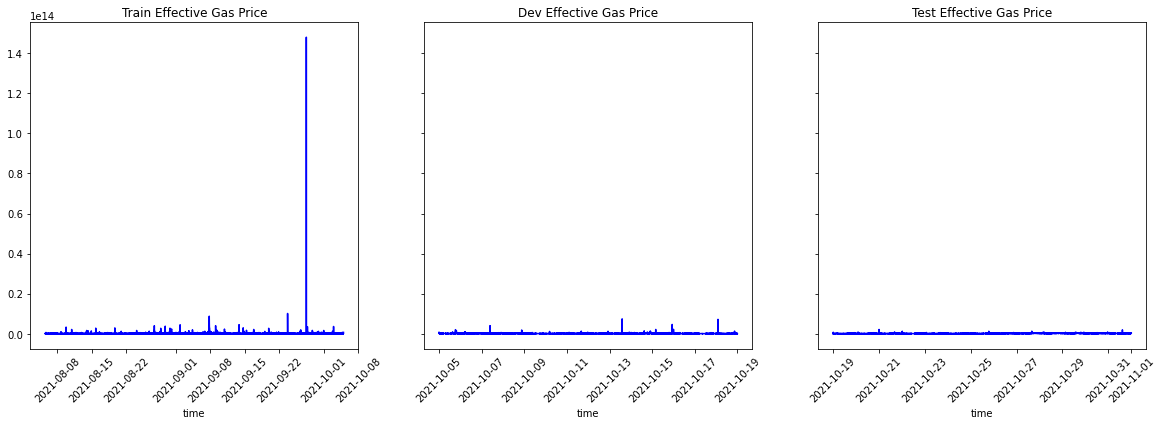

In [30]:
fig, ax1 = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

ax1[0].plot(X_train['datetime'], Y_train, color='blue')
ax1[0].set_xlabel('time')
ax1[0].tick_params(axis='x', labelrotation=45)
ax1[0].set_title('Train Effective Gas Price')
#plt.show()

ax1[1].plot(X_dev['datetime'], Y_dev, color='blue')
ax1[1].set_xlabel('time')
ax1[1].tick_params(axis='x', labelrotation=45)
ax1[1].set_title('Dev Effective Gas Price')
#plt.show()

ax1[2].plot(X_test['datetime'], Y_test, color='blue')
ax1[2].set_xlabel('time')
ax1[2].tick_params(axis='x', labelrotation=45)
ax1[2].set_title('Test Effective Gas Price')
plt.show()

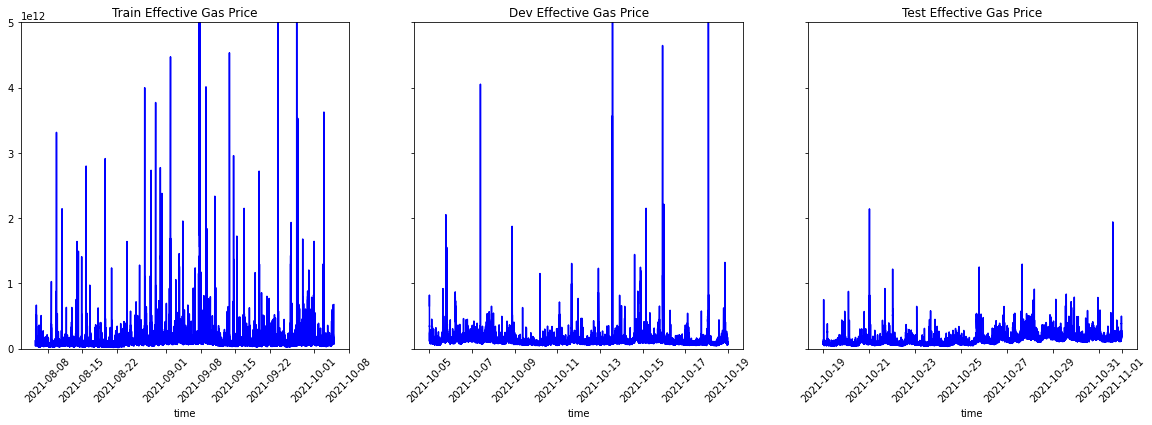

In [31]:
fig, ax1 = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

ax1[0].plot(X_train['datetime'], Y_train, color='blue')
ax1[0].set_xlabel('time')
ax1[0].tick_params(axis='x', labelrotation=45)
ax1[0].set_title('Train Effective Gas Price')
ax1[0].set_ylim(0, 5000000000000)
#plt.show()

ax1[1].plot(X_dev['datetime'], Y_dev, color='blue')
ax1[1].set_xlabel('time')
ax1[1].tick_params(axis='x', labelrotation=45)
ax1[1].set_title('Dev Effective Gas Price')
ax1[1].set_ylim(0, 5000000000000)
#plt.show()

ax1[2].plot(X_test['datetime'], Y_test, color='blue')
ax1[2].set_xlabel('time')
ax1[2].tick_params(axis='x', labelrotation=45)
ax1[2].set_title('Test Effective Gas Price')
ax1[2].set_ylim(0, 5000000000000)
plt.show()

In [32]:
Y_train.describe(percentiles=[.01, .05, .10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,effective_gas_price_mean
count,3.782710e+05
mean,9.284552e+10
std,2.715820e+11
min,1.596813e+10
1%,2.840550e+10
5%,3.656959e+10
10%,4.188432e+10
25%,5.305154e+10
50%,7.268458e+10
75%,1.014788e+11


## Run a Random Forest Model

In [34]:
rf_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']

In [35]:
# Instantiate the random forest
rf = RandomForestRegressor(n_estimators = 100, 
                           max_depth = 10,
                           bootstrap = True,
                           max_features = 7,
                           min_samples_leaf = 50,
                           random_state = 42)

# Train the model on the training data
rf.fit(X_train[rf_features], Y_train)

# Get the predictions on the training data set
rf_train_predictions = rf.predict(X_train[rf_features])

# Get the predictions on the dev data set
rf_dev_predictions = rf.predict(X_dev[rf_features])


rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
rf_RMSE_train = np.sqrt(rf_MSE_train)
rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
rf_RMSE_dev = np.sqrt(rf_MSE_dev)
print("rf_RMSE_train:", rf_RMSE_train)
print("rf_RMSE_dev:", rf_RMSE_dev)


rf_RMSE_train: 246611756443.7396
rf_RMSE_dev: 85945242269.28065


#### Save the model

In [42]:
import pickle
with open(r'data/rf_test_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Load the model from file

In [43]:
with open('data/rf_test_model.pkl', 'rb') as f:
    rf_from_file = pickle.load(f)

In [44]:
# Make predictions from model from file
rf_from_file_train_preds = rf_from_file.predict(X_train[rf_features])
rf_from_file_dev_preds = rf_from_file.predict(X_dev[rf_features])

# Check model from file on training data

In [45]:
# Initial train predictions
rf_train_predictions

array([4.12350232e+11, 4.36909897e+11, 3.45560267e+11, ...,
       5.52948656e+11, 5.25423390e+11, 5.25589371e+11])

In [46]:
# From file model train predictions
rf_from_file_train_preds

array([4.12350232e+11, 4.36909897e+11, 3.45560267e+11, ...,
       5.52948656e+11, 5.25423390e+11, 5.25589371e+11])

In [47]:
# Check difference between trained model and model from file
rf_train_predictions - rf_from_file_train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
# Check that all predictions match
(rf_train_predictions - rf_from_file_train_preds).sum()

0.0

# Check model from file on dev data

In [52]:
# Initial train predictions
rf_dev_predictions

array([5.47475659e+11, 5.64634274e+11, 5.56842399e+11, ...,
       8.18188217e+10, 7.60398798e+10, 7.54170225e+10])

In [53]:
# From file model train predictions
rf_from_file_dev_preds

array([5.47475659e+11, 5.64634274e+11, 5.56842399e+11, ...,
       8.18188217e+10, 7.60398798e+10, 7.54170225e+10])

In [54]:
# Check difference between trained model and model from file
rf_dev_predictions - rf_from_file_dev_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [55]:
# Check that all predictions match
(rf_dev_predictions - rf_from_file_dev_preds).sum()

0.0